## Get data from excel file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cvxopt as opt
from cvxopt import blas, solvers
solvers.options['show_progress'] = False
def optimal_portfolio(returns):
    #n = len(returns)
    # Turn returns into a matrix which has its rows corresponding to daily returns of stocks
    returns = np.asmatrix(returns).T
    n = returns.shape[0] # n is the number of assents in returns
    
    ## Choose N different values for the Lagrange multiplier
    N = 100
    lambdas = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    
    #pbar = opt.matrix(np.mean(returns, axis=1))
    ## Calculate the mean returns of all stocks: returns of each stock is given in a column
    pbar = opt.matrix(np.mean(returns, axis=1))
    #print(np.asmatrix(pbar).shape)
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(lbda*S, -pbar, G, h, A, b)['x'] 
                  for lbda in lambdas]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    factor_annualize = 252 # make the rtns and risk into annualized quantities
    rtns = [factor_annualize*blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(factor_annualize*blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(rtns, risks, 2)
    #print('m1 dimensions: ', np.shape(m1))
    x1 = np.sqrt(m1[2] / m1[0])
    #print('x1 is: ', x1)
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), rtns, risks

## P1 A

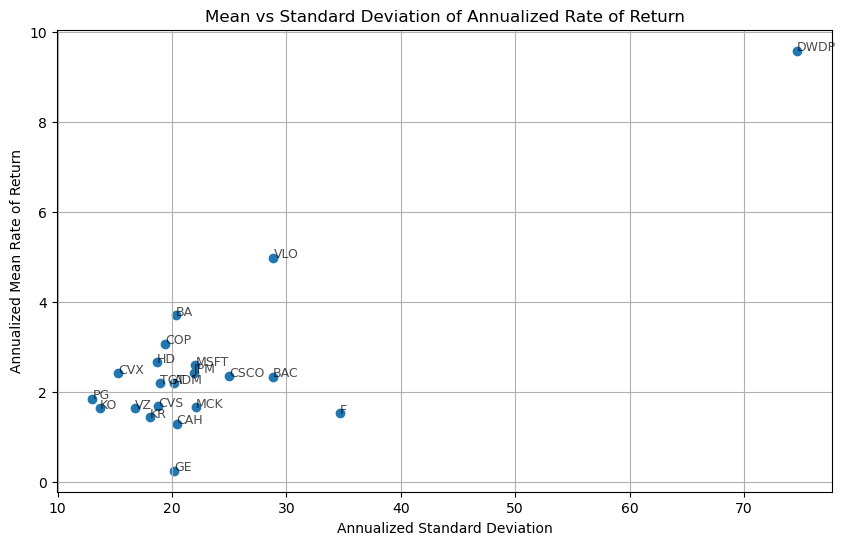

In [ ]:
ticker=pd.ExcelFile('data.xlsx').sheet_names[:21]
rate_of_return_dfs = []
excel_file = pd.ExcelFile('data.xlsx')
for t in ticker:
    df = excel_file.parse(t)
    rate_of_return_dfs.append(df[['Rate of Return']].rename(columns={'Rate of Return': t}))

combined_rate_of_return = pd.concat(rate_of_return_dfs, axis=1)
combined_rate_of_return.dropna(inplace=True)
means = combined_rate_of_return.mean().tolist()
stds = combined_rate_of_return.std().tolist()
returns_annual = [m * 12 for m in means]
cov_annual = combined_rate_of_return.cov() * np.sqrt(12)
stds = [s * np.sqrt(12) for s in stds]
plt.figure(figsize=(10, 6))
plt.scatter(stds, returns_annual)
for i, label in enumerate(ticker):
    plt.annotate(label, (stds[i], returns_annual[i]), fontsize=9, alpha=0.7)
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Rate of Return')
plt.title('Mean vs Standard Deviation of Annualized Rate of Return')
plt.grid(True)
plt.show()

## P1 B

In [3]:
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

# set the number of combinations for imaginary portfolios
#stk_set = ['KO', 'F', 'WMT', 'GE', 'TSLA','GS', 'AAPL']
num_portfolios = 500

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.uniform(-1, 1, len(ticker))
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

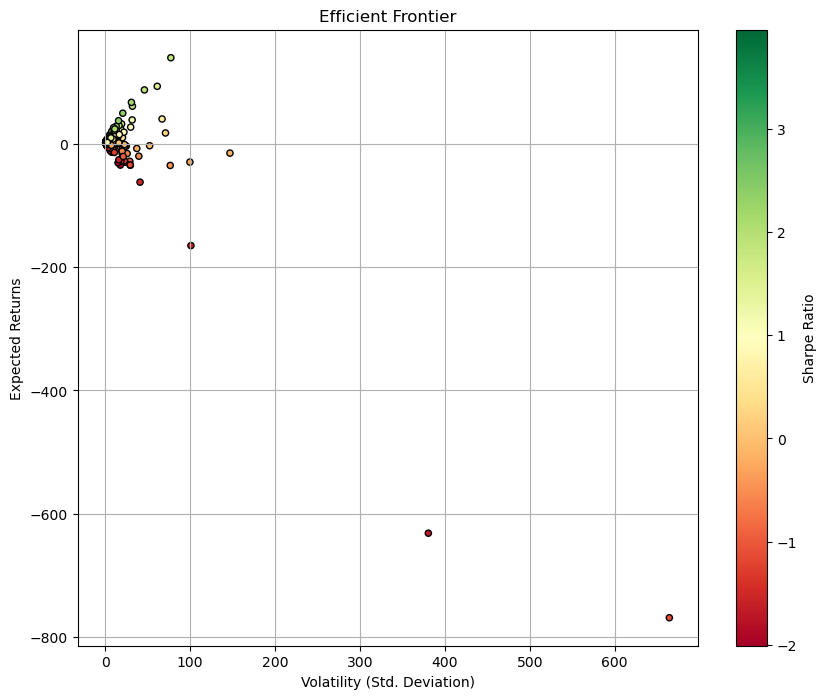

In [4]:
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}
for counter,symbol in enumerate(ticker):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

df = pd.DataFrame(portfolio)
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' weight' for stock in ticker]
df = df[column_order]
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

## P1 C

m1 dimensions:  (3,)
x1 is:  3.345363412400195


Text(0.5, 0, 'standard deviation')

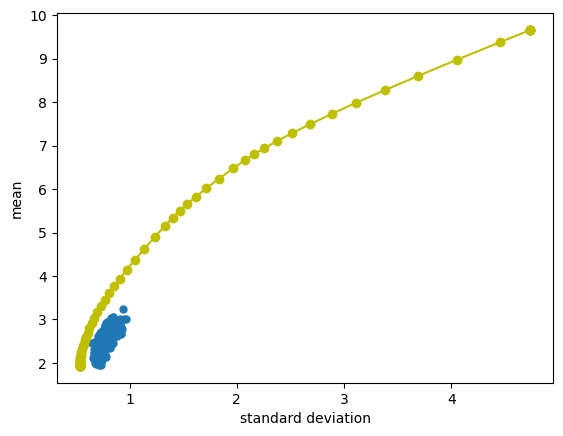

In [2]:
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

# Turn off progress printing 
solvers.options['show_progress'] = False
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

# set the number of combinations for imaginary portfolios
#stk_set = ['KO', 'F', 'WMT', 'GE', 'TSLA','GS', 'AAPL']
num_portfolios = 500

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.uniform(0, 1, len(ticker))
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}
return_vec = combined_rate_of_return.dropna()
weights, returns, risks = optimal_portfolio(return_vec)
means = portfolio['Returns']
stds = portfolio['Volatility']

fig = plt.figure()

plt.plot(stds, means, 'o', markersize=5)
plt.plot(risks, returns, 'y-o')
plt.ylabel('mean')
plt.xlabel('standard deviation')



## P2

In [2]:
ticker = pd.ExcelFile('data.xlsx').sheet_names[:21]
price = []
rate_of_return_dfs = []
row_names = []
excel_file = pd.ExcelFile('data.xlsx')
for t in ticker:
    df = excel_file.parse(t)
    # Read Adj Close
    adj_close = df[['Date', 'Adj Close',"Rate of Return"]].copy()
    adj_close.columns = ['Date', t,f"{t} Rate of Return"]
    adj_close.set_index('Date', inplace=True)
    price.append(adj_close)

# After the loop, combine all into a single DataFrame
price_df = pd.concat(price, axis=1)
rateofreturn = price_df[[f"{t} Rate of Return" for t in ticker]]
rateofreturn= rateofreturn.dropna()
weights, returns, risks=optimal_portfolio(rateofreturn.loc["1999-01-01":"2014-12-01"].values)
weights = np.array(weights).flatten()
equal_weights = np.ones(len(ticker)) * 1 / len(ticker)
monthly_return=rateofreturn.loc["2015-01-01":"2019-05-01"].values @ weights
print(f"Expected return of portfolio x: {monthly_return.mean()}")
print(f"Risk of portfolio x: {monthly_return.std()}")
monthly_return=rateofreturn.loc["2015-01-01":"2019-05-01"].values @ equal_weights
print(f"Expected return of portfolio y: {monthly_return.mean()}")
print(f"Risk of portfolio y: {monthly_return.std()}")

Expected return of portfolio x: 0.012763572616573914
Risk of portfolio x: 0.050425769820352254
Expected return of portfolio y: 0.009113879348367774
Risk of portfolio y: 0.043024190273826896


## P3

In [2]:
ticker = pd.ExcelFile('data.xlsx').sheet_names[:21]
price = []
rate_of_return_dfs = []
row_names = []
excel_file = pd.ExcelFile('data.xlsx')
for t in ticker:
    df = excel_file.parse(t)
    # Read Adj Close
    adj_close = df[['Date', 'Adj Close',"Rate of Return"]].copy()
    adj_close.columns = ['Date', t,f"{t} Rate of Return"]
    adj_close.set_index('Date', inplace=True)
    price.append(adj_close)

# After the loop, combine all into a single DataFrame
price_df = pd.concat(price, axis=1)

In [3]:
from dateutil.relativedelta import relativedelta
def minus_months(date_str,delta):
    # Assumes date_str is in 'YYYY-MM-DD' format
    date = pd.to_datetime(date_str)
    new_date = date - relativedelta(months=delta)
    return new_date.strftime('%Y-%m-%d')
def n_m(n,m):
    current_time='2014-12-01'
    only_price=price_df[ticker]
    R_1 = np.log(only_price.loc[minus_months(current_time,1)] / only_price.loc[minus_months(current_time,n)])
    R_2 = np.log(only_price.loc[minus_months(current_time,m)] / only_price.loc[minus_months(current_time,1)])
    M_1_score = (R_1 + R_2) * 0.5
    selected_tickers=list(M_1_score.nlargest(10).index)
    rateofreturn = price_df[[f"{ticker} Rate of Return" for ticker in selected_tickers]]
    rateofreturn= rateofreturn.dropna()
    weights, returns, risks=optimal_portfolio(rateofreturn.loc["1999-01-01":"2014-12-01"].values)
    return weights,selected_tickers


In [4]:
n_list=[1,2,3,4,5,6]
m_list=[3,4,5,6,7,8,9]
results = {}
for n in n_list:
    for m in m_list:
        weights,tickerlist = n_m(n,m)  # Change n and m values as needed
        means = []
        stds = []
        for t in tickerlist:
            rates = price_df[f"{t} Rate of Return"].dropna()
            means.append(rates.mean())
            stds.append(rates.std())
        results[(n,m)] = np.dot(weights.T, means)
sorted(results.items(), key=lambda x: x[1], reverse=True)
# n=1,m=9 has highest expected return

[((1, 9), array([0.01563213])),
 ((2, 6), array([0.01533471])),
 ((2, 7), array([0.01533471])),
 ((3, 6), array([0.01533471])),
 ((1, 6), array([0.01531926])),
 ((1, 8), array([0.01531926])),
 ((1, 7), array([0.01531926])),
 ((2, 5), array([0.01528491])),
 ((2, 4), array([0.01528491])),
 ((2, 9), array([0.01513756])),
 ((5, 8), array([0.01475963])),
 ((1, 4), array([0.01468934])),
 ((5, 4), array([0.01463458])),
 ((5, 7), array([0.01461176])),
 ((2, 8), array([0.01451923])),
 ((3, 8), array([0.01451923])),
 ((6, 8), array([0.01451113])),
 ((6, 7), array([0.01450419])),
 ((4, 7), array([0.01443867])),
 ((3, 7), array([0.01441124])),
 ((3, 9), array([0.01433417])),
 ((1, 5), array([0.01410372])),
 ((3, 5), array([0.01408611])),
 ((3, 3), array([0.01384711])),
 ((3, 4), array([0.01381553])),
 ((6, 4), array([0.0137503])),
 ((1, 3), array([0.01374402])),
 ((5, 6), array([0.01363331])),
 ((6, 6), array([0.01363278])),
 ((4, 8), array([0.01321734])),
 ((4, 9), array([0.0132084])),
 ((5, 9), 

In [5]:
weights,tickerlist = n_m(1,9)  # using n=1,m=9 try to compare with equal weight portfolio
means = []
stds = []
tickers=[f"{t} Rate of Return" for t in tickerlist]
weights = np.array(weights).flatten()
rates = price_df[tickers].dropna()
print(f"Selected portfolio expected return annual : {12*np.dot(weights,rates.mean())}")
print(f"Selected portfolio risk annual: {np.sqrt(12)*weights.T@rates.cov()@weights}")
equal_weights = np.ones(len(tickerlist)) * 1 / len(tickerlist)
print(f"Equal weighted portfolio expected return annual: {12*np.dot(equal_weights,rates.mean())}")
print(f"Equal weighted portfolio risk annual: {np.sqrt(12)*equal_weights.T@rates.cov()@equal_weights}")

Selected portfolio expected return annual : 0.18758552079542823
Selected portfolio risk annual: 0.013980953370341994
Equal weighted portfolio expected return annual: 0.15307038067152293
Equal weighted portfolio risk annual: 0.015151048462055635
